In [24]:

import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import Generative_model as gm
import arviz as az
from pymc import Model, Normal, Slice, sample
from pymc.distributions import Interpolated
import pandas as pd


In [2]:
#theta is the way the frame is oriented

#the generated participant true mu & sigma 
mu , sigma = gm.analytical_solution(5,40,0.8,6,0)
#generate a single response with 1 being clockwise and 0 being counter clockwise given a specific degree
response_list = []
for i in range(-8,8,1):
    response_list.append(gm.sample_response(mu,sigma,i))





[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1]


Lets recreate the experiment to see how much percent of the earth is water

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

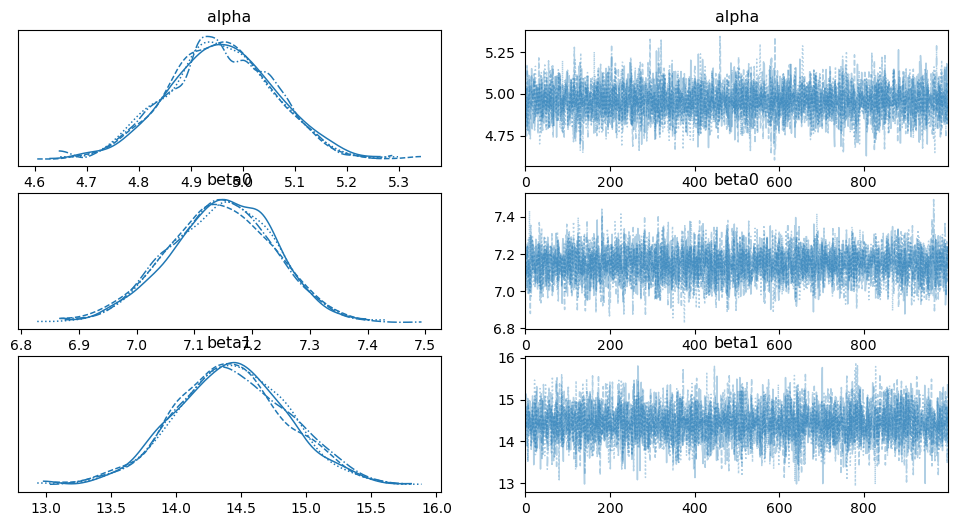

In [4]:
# Initialize random number generator
np.random.seed(93457)

# True parameter values
alpha_true = 5
beta0_true = 7
beta1_true = 13

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = Normal("alpha", mu=0, sigma=1)
    beta0 = Normal("beta0", mu=12, sigma=1)
    beta1 = Normal("beta1", mu=18, sigma=1)

    # Expected value of outcome
    mu = alpha + beta0 * X1 + beta1 * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    # draw 1000 posterior samples
    trace = sample(1000)
az.plot_trace(trace) 


In [5]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

0       4.980158
1       4.889920
2       4.857914
3       4.877394
4       4.787902
          ...   
3995    5.160009
3996    4.999765
3997    4.940562
3998    4.821021
3999    4.930464
Name: alpha, Length: 4000, dtype: float64


In [39]:
test = trace.posterior["alpha"]

<xarray.DataArray 'alpha' (draw: 1000)>
array([4.9575471 , 4.95553367, 4.92010036, 4.98984808, 4.98984808,
       4.93429032, 4.95149375, 4.89628239, 4.94423702, 4.92766162,
       4.98086607, 4.92498778, 4.96900858, 4.94701956, 4.94385955,
       4.9372782 , 4.91595008, 4.99623772, 4.97478823, 4.95381716,
       4.99189651, 4.95917646, 4.9267991 , 5.02351274, 4.93174108,
       4.93819407, 4.86396064, 4.95705018, 4.90690398, 4.98064034,
       4.88889626, 5.03287424, 4.92260673, 4.96461147, 4.95118389,
       4.94492143, 4.94492143, 4.93432083, 4.94320138, 4.95639477,
       4.94943958, 4.94153048, 4.90641126, 5.00068587, 5.01860421,
       4.91831143, 4.9309688 , 4.94802881, 4.94535526, 4.94130823,
       4.94326288, 4.96679341, 4.97844459, 4.86847533, 4.84084054,
       4.96089877, 4.92638329, 4.92996198, 4.92996198, 4.94894581,
       4.93547177, 5.02416839, 4.98605741, 5.02594278, 5.01904754,
       4.99357578, 4.91356781, 4.92764869, 4.98419753, 4.9602895 ,
       4.92367025, 4.9

In [40]:



for _ in range(10):
    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior("alpha", trace.posterior["alpha"])
        beta0 = from_posterior("beta0", trace.posterior["beta0"])
        beta1 = from_posterior("beta1", trace.posterior["beta1"])

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

        # draw 10000 posterior samples
        trace = sample(1000)

        
        
        




ValueError: points have dimension 1, dataset has dimension 4

In [25]:
print("Posterior distributions after " + str(len(df)) + " iterations.")
cmap = mpl.cm.autumn

for param in ["alpha", "beta0", "beta1"]:
    plt.figure(figsize=(8, 2))
    
    for update_i in range(len(df)):
        samples = df[param].iloc[update_i]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(df)))
    
    plt.axvline({"alpha": alpha_true, "beta0": beta0_true, "beta1": beta1_true}[param], c="k")
    plt.ylabel("Frequency")
    plt.title(param)

plt.tight_layout()

Posterior distributions after 44000 iterations.


ValueError: `dataset` input should have multiple elements.

<Figure size 800x200 with 0 Axes>